In [332]:
import glob
import os
import numpy as np
import pandas as pd
import sounddevice as sd
import pylab as pl
import random

from scipy.io import wavfile
import matplotlib.pyplot as plt
from python_speech_features import mfcc
from sklearn.cluster import MiniBatchKMeans

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from adjustText import adjust_text
from collections import Counter
from scipy.io.wavfile import write
from sklearn.cluster import AgglomerativeClustering

from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import ShortTermFeatures

%matplotlib inline

In [331]:
def get_clip_indexes(cluster_label, clusters):
    clips_i = []
    for i in range(len(clusters)):
        if clusters[i] == cluster_label:
            clips_i.append(i)
    return clips_i

def play_random_clip_in_cluster(index, clusters, option='cluster'):
    assert(option == 'cluster' or option == 'clip')
    if option == 'clip':
        index = find_cluster(index, clusters) # Get cluster index
    
    clips = get_clip_indexes(index, clusters)
    clip_i = clips[random.randint(0, len(clips) - 1)]
    print('Playing clip index %d ' % clip_i)
    play_clip(clip_i)
        
def find_cluster(clip_index, clusters):
    return clusters[clip_index]

def play_clip(clip_index):
    samples = shorter_clips[clip_index]
    samplerate = 16000
    sd.play(samples, samplerate)

def list_flatten(l):
    flat_list = []
    for sublist in l:
        for item in sublist:
            flat_list.append(item)
    return flat_list

def save_clip(filename, wav_array):
    assert('.' not in filename)
    write(filename + '.wav', samplerate, wav_array)

## Load Audio Data

In [2]:
dir_path = './GY01/'

samplerate = None
wav_data = []
for file in glob.glob(dir_path + '*.wav'):
    try: 
        rate, data = wavfile.read(file)
        samplerate = rate
        if wav_data == []:
            wav_data = data
        else:
            wav_data = np.concatenate((wav_data, data))
        print(file)
    except Exception as e:
        print('(failed) ' + file)
        print('\t' + str(e))
        pass
    
print('number of channels = %d' % wav_data.shape[1])
print('sample rate = %d' % samplerate)
length = wav_data.shape[0] / samplerate
print('length = %.1fs' % length)

C:\Users\Erika\anaconda3\envs\Python3-7\lib\site-packages\ipykernel_launcher.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  import sys


./GY01\S4A03418_20180811_105010.wav


C:\Users\Erika\anaconda3\envs\Python3-7\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


./GY01\S4A03418_20180811_135008.wav
./GY01\S4A03418_20180811_145008.wav
./GY01\S4A03418_20180811_205008.wav
number of channels = 2
sample rate = 16000
length = 14390.0s


## Split Audio Data

In [3]:
# Get n-minute clips
def split_into_minutes(wav_data, samplerate, n=1):
    length_in_seconds = len(wav_data) / samplerate
    length_in_minutes = length_in_seconds / 60
    length_in_minutes = int(length_in_minutes / n)

    cut_wav_data = wav_data[:-((len(wav_data)) % length_in_minutes)]
    shorter_clips = np.split(cut_wav_data, length_in_minutes)
    print('%d %d-minute clips' % (len(shorter_clips), n))
    return shorter_clips

# Get n-second clips
def split_into_n_seconds(wav_data, samplerate, n=10):
    length_in_seconds = len(wav_data) / samplerate
    length_in_minutes = length_in_seconds / 60
    length_in_minutes = int(length_in_minutes)
    shorter_len = int(length_in_minutes / (1/(60/n)))
    
    cut_wav_data = wav_data[:-((len(wav_data)) % shorter_len)]
    second_clips = np.split(cut_wav_data, shorter_len)
    print('%d %d-second clips' % (len(second_clips), n))
    return second_clips

In [4]:
#shorter_clips = split_into_minutes(wav_data, samplerate, 1)
shorter_clips = split_into_n_seconds(wav_data, samplerate, 10)

1434 10-second clips


# Spectrograms

In [340]:
def plot_spectrogram(samplerate, shorter_clips, clip_index, separate_channels=False):
    left_channel = shorter_clips[clip_index][:, 0]
    right_channel = shorter_clips[clip_index][:, 1]
    
    plt.rcParams["figure.figsize"] = (100, 100)
    plt.rcParams.update({'font.size': 50})
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    
    plt.subplot(211)
    if separate_channels:
        plt.title('Clip #%d (Left Channel)' % clip_index)
        plt.specgram(left_channel, Fs=samplerate)
        plt.subplot(212)
        plt.title('Clip #%d (Right Channel)' % clip_index)
        plt.specgram(right_channel, Fs=samplerate)
    else:
        plt.title('Clip #%d' % clip_index)
        both_channels = left_channel + right_channel
        plt.specgram(both_channels, Fs=samplerate)

    plt.show()
    
def plot_spectrogram_of_cluster(samplerate, shorter_clips, cluster_i, clusters, separate_channels=False):
    clip_indexes = get_clip_indexes(cluster_i, clusters)
    
    left_channel = shorter_clips[clip_indexes[0]][:, 0]
    right_channel = shorter_clips[clip_indexes[0]][:, 1]
    
    for i in range(1, len(clip_indexes)):
        left_channel = np.append(left_channel, shorter_clips[clip_indexes[i]][:, 0])
        right_channel = np.append(right_channel, shorter_clips[clip_indexes[i]][:, 1])
    
    plt.rcParams["figure.figsize"] = (100, 100)
    plt.rcParams.update({'font.size': 50})
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    
    plt.subplot(211)
    if separate_channels:
        plt.title('Cluster #%d (Left Channel)' % cluster_i)
        plt.specgram(left_channel, Fs=samplerate)
        plt.subplot(212)
        plt.title('Cluster #%d (Right Channel)' % cluster_i)
        plt.specgram(right_channel, Fs=samplerate)
    else:
        plt.title('Cluster #%d' % cluster_i)
        both_channels = left_channel + right_channel
        plt.specgram(both_channels, Fs=samplerate)

    plt.show()

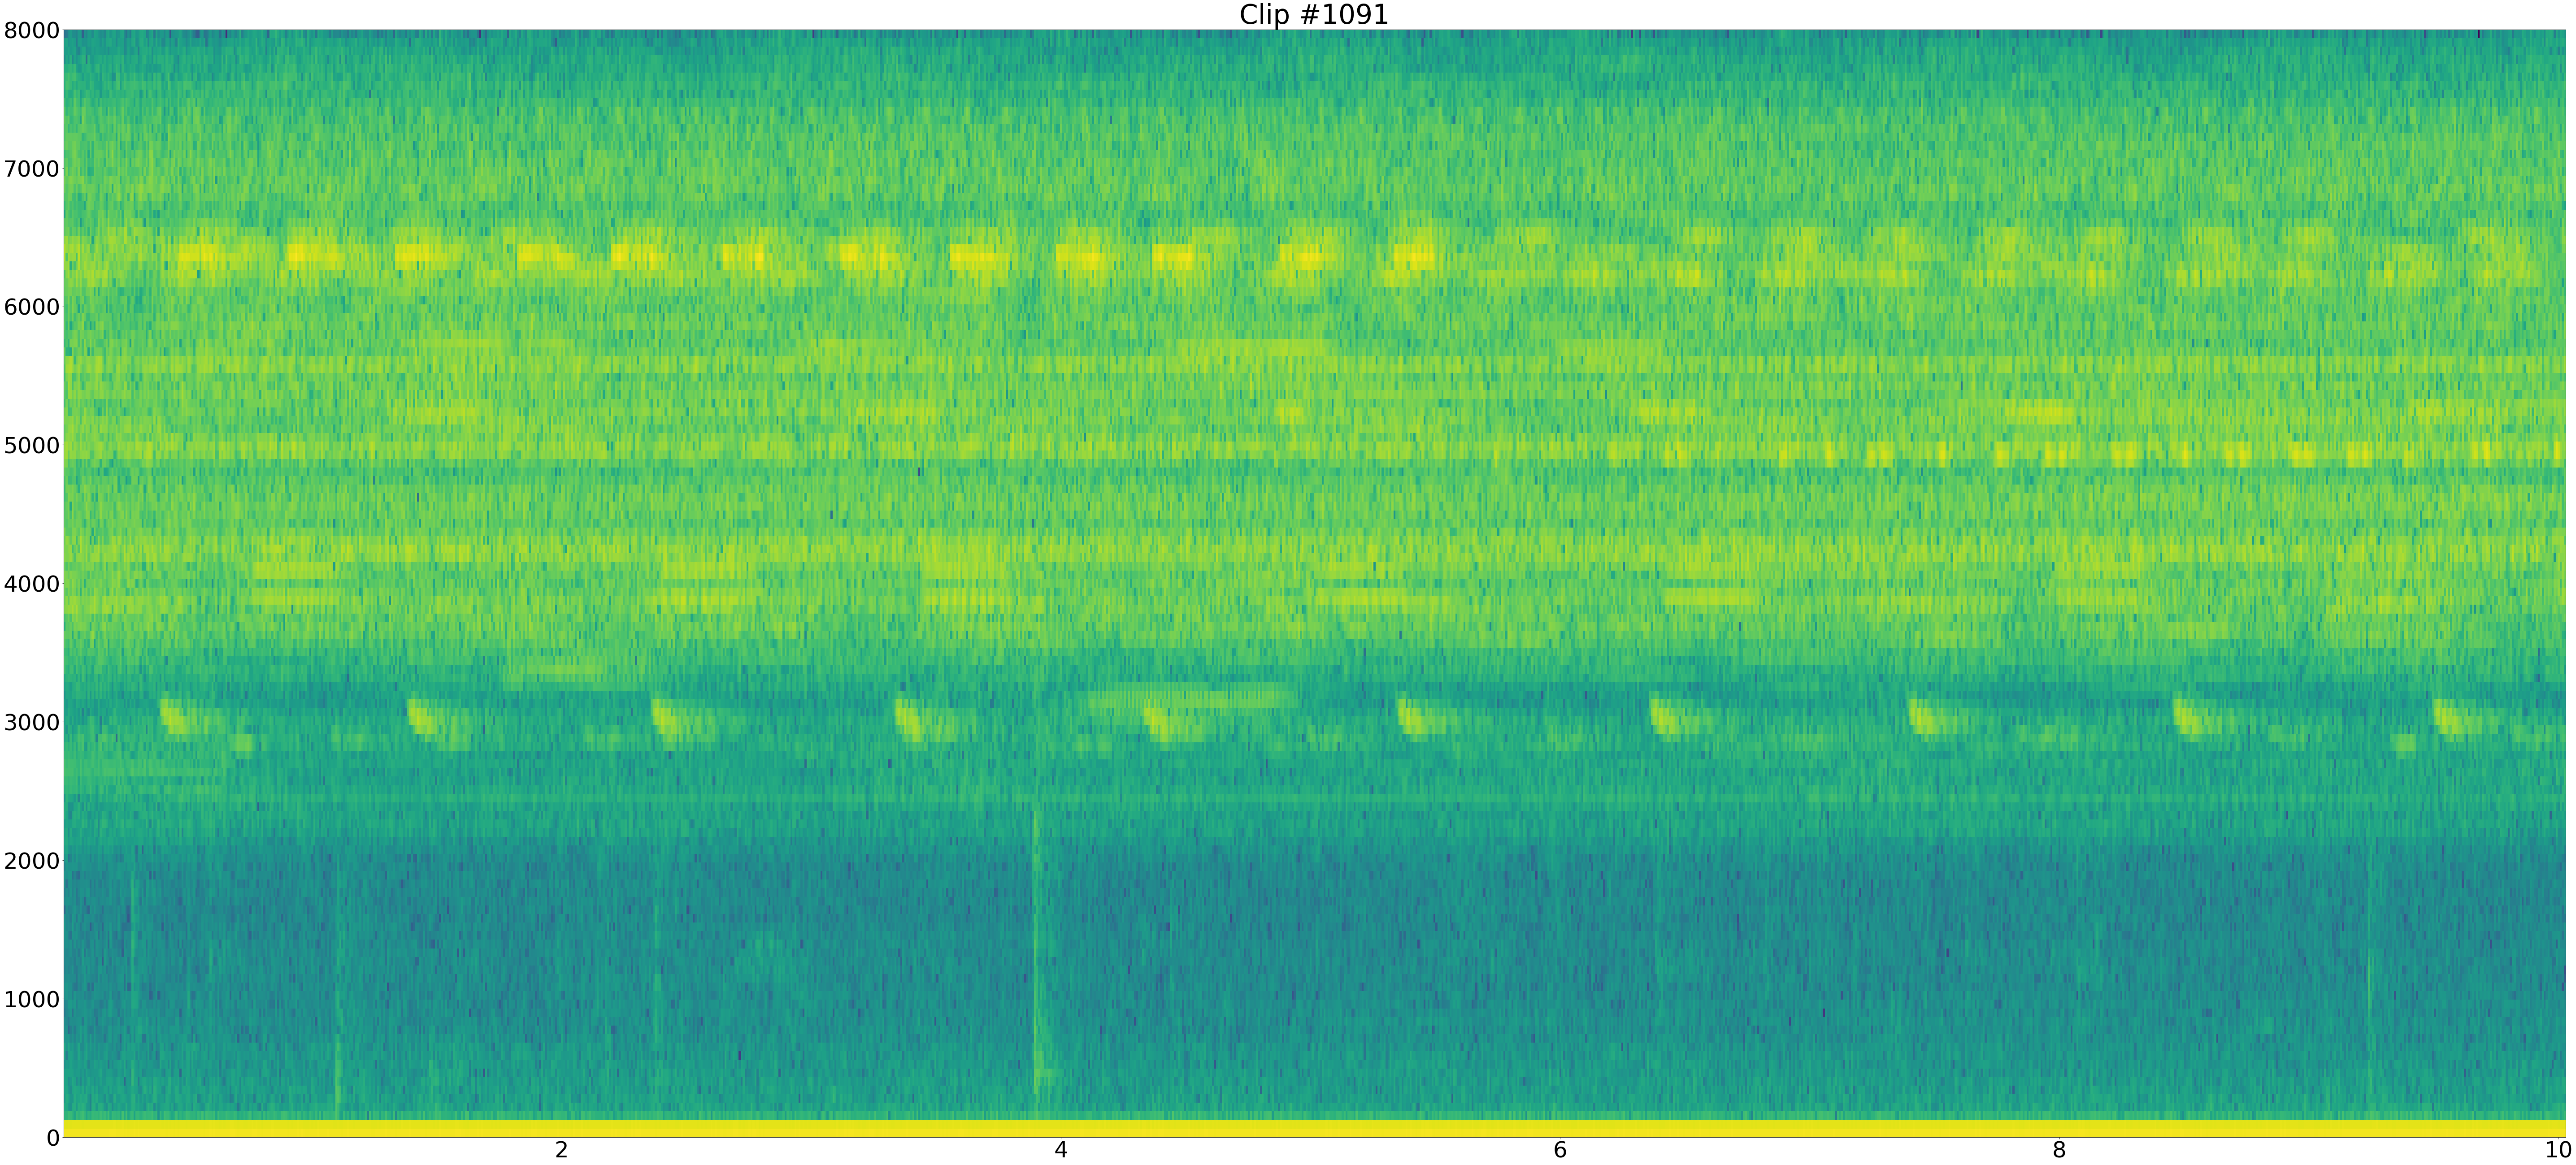

In [6]:
plot_spectrogram(samplerate, shorter_clips, 1091)

# Feature Extraction

In [348]:
# TODO: Add a way to select and evaluate features

def extract_features(shorter_clips, mfcc_only=False):
    feat_clips = []

    print('Extracting features for each of the %d audio clips' % len(shorter_clips))
    for clip in shorter_clips:
        clip = clip[:, 0] + clip[:, 1] # Merging left and right channels

        mfcc_feat=None
        if mfcc_only:
            mfcc_feat = mfcc(clip, samplerate).flatten()

        else:
            mfcc_feat = ShortTermFeatures.feature_extraction(clip, samplerate, 0.050*samplerate, 0.025*samplerate)

        # Append the features
        if mfcc_only:
            feat_clips.append(mfcc_feat)
        else:
            feat_clips.append(list_flatten(mfcc_feat[0]))

    print('done')
    return feat_clips
    
# Set mfcc_only to True to shorten runtime
feat_clips = extract_features(shorter_clips, mfcc_only=True)
#all_feat_clips = extract_features(shorter_clips)

Extracting features for each of the 1434 audio clips
done


# Clustering

In [354]:
def cluster_plot(pos, title='', without_labels=False, width=20, height=20):
    plt.rc('font', size=15)
    
    xs, ys = pos[:, 0], pos[:, 1]
    
    labels = range(len(shorter_clips))

    # Data frame with TSNE data, the cluster numbers and titles
    cluster_df = pd.DataFrame(dict(x=xs, y=ys, clusters=clusters, labels=labels)) 

    fig, ax = plt.subplots(figsize=(width, height))
    ax.margins(0.05)
    ax.set_title(title)

    groups = cluster_df.groupby('clusters')
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, mec='none', label=name)
        ax.set_aspect('auto')
        ax.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
        ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')

    ax.legend(numpoints=1)
    ax.legend(bbox_to_anchor=(1.2, 1.05))

    #Add labels
    if not without_labels:
        texts = []
        for i in range(len(cluster_df)):
            texts.append(ax.text(cluster_df.loc[i, 'x'], cluster_df.loc[i, 'y'], cluster_df.loc[i,'labels'], size=10)) 

        #adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
        #plt.savefig('./images/clusters.png', dpi=200)

    plt.show()

In [126]:
# Choose number of clusters
n_clusters = 10

# Fit clustering model
clusters = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward').fit_predict(features)

### All PyAudioAnalysis Features

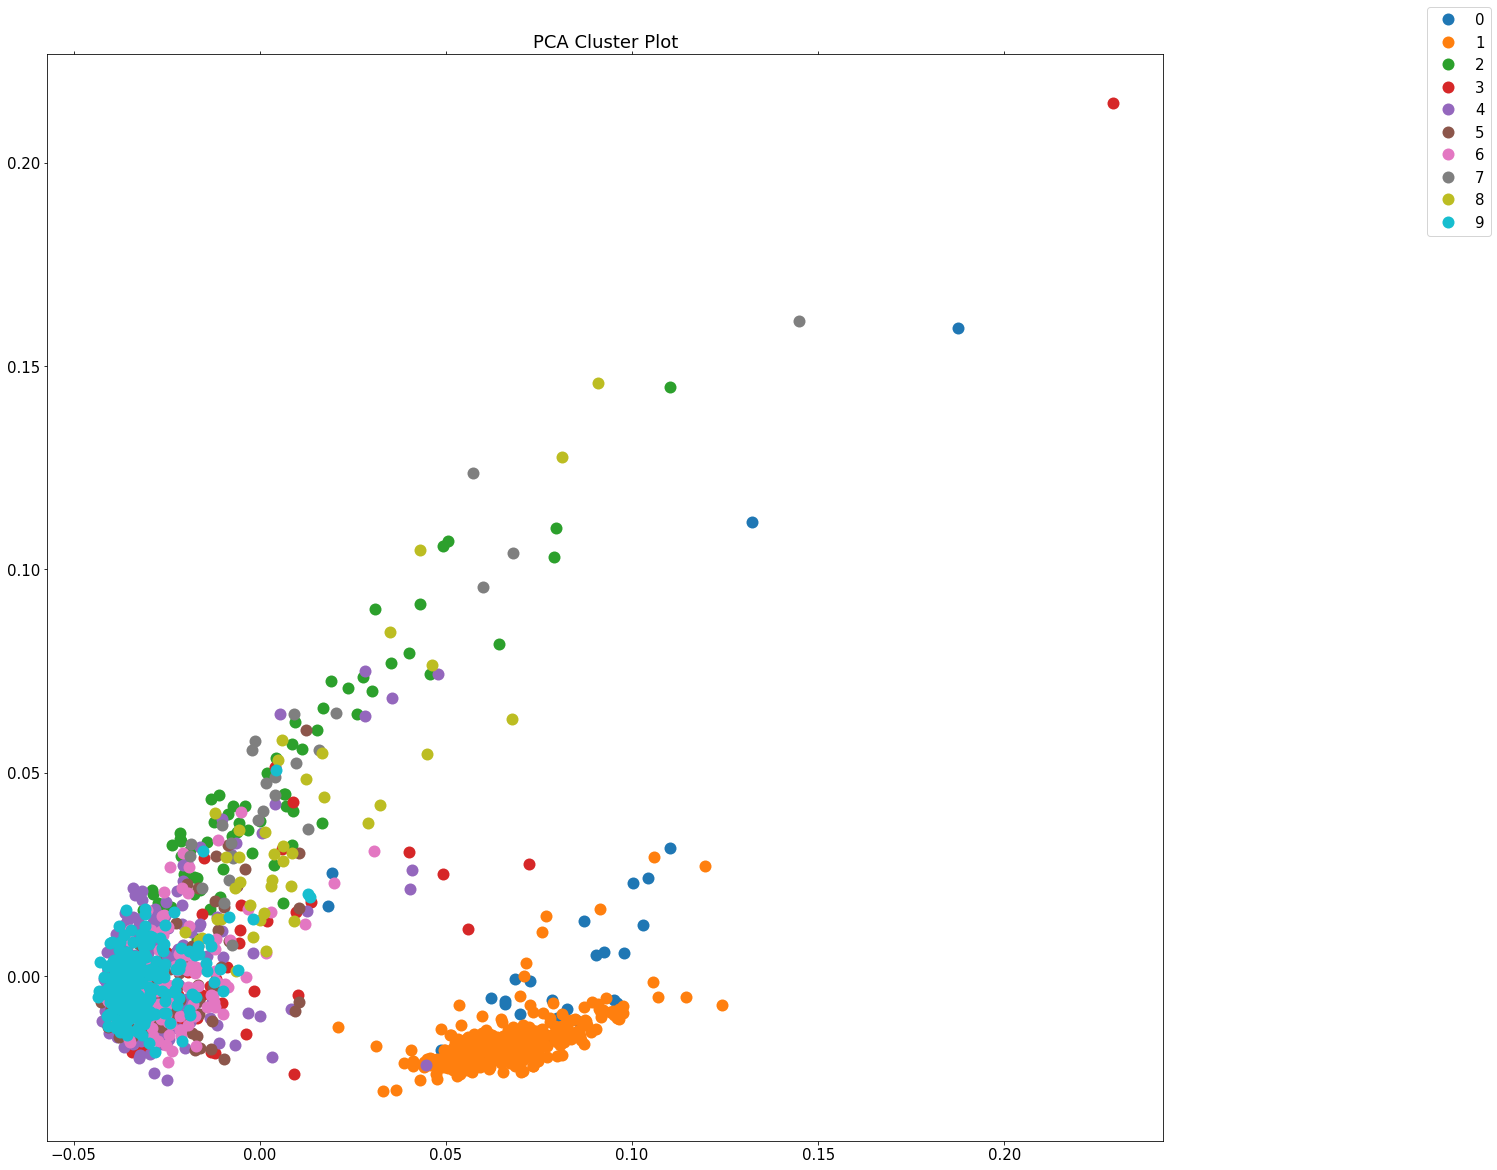

In [132]:
# Project the data onto 2D graph - 10 clusters
dist = 1 - cosine_similarity(features)
mds = PCA(n_components=2, random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

cluster_plot(pos, 'PCA Cluster Plot', without_labels=True)

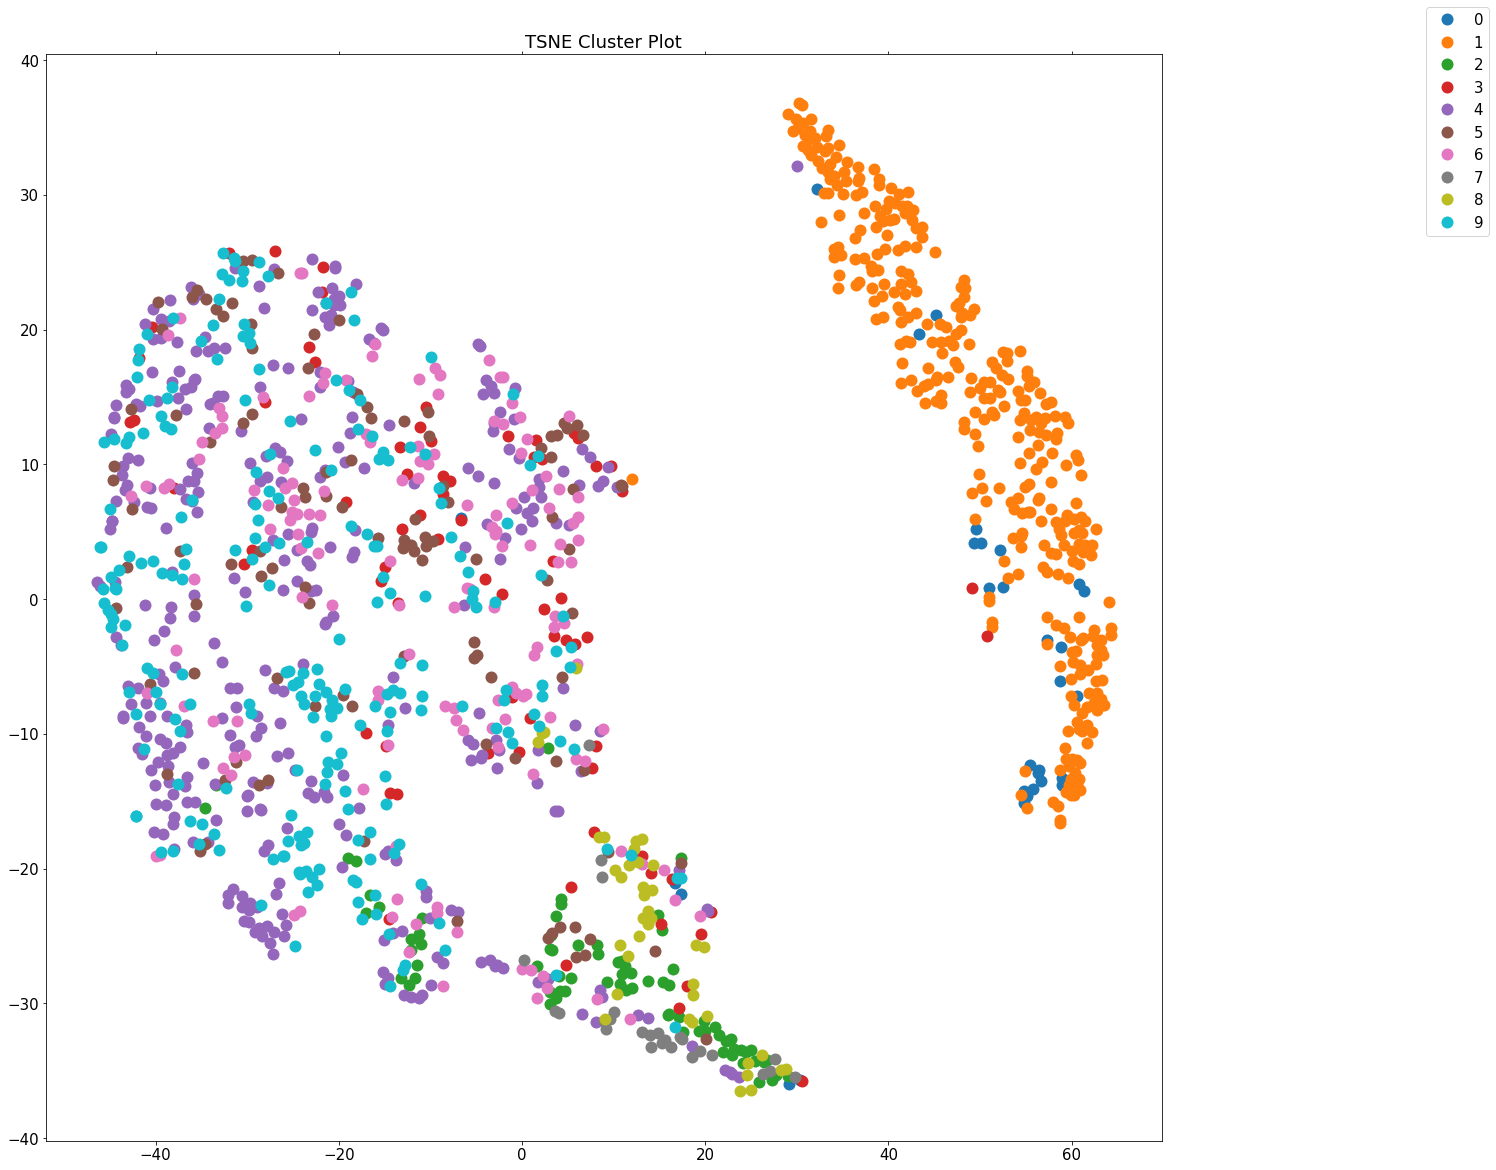

In [131]:
# Project the data onto 2D graph - 10 clusters
dist = 1 - cosine_similarity(features)
mds = TSNE(n_components=2, random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

cluster_plot(pos, 'TSNE Cluster Plot', without_labels=True)

### MFCC Only

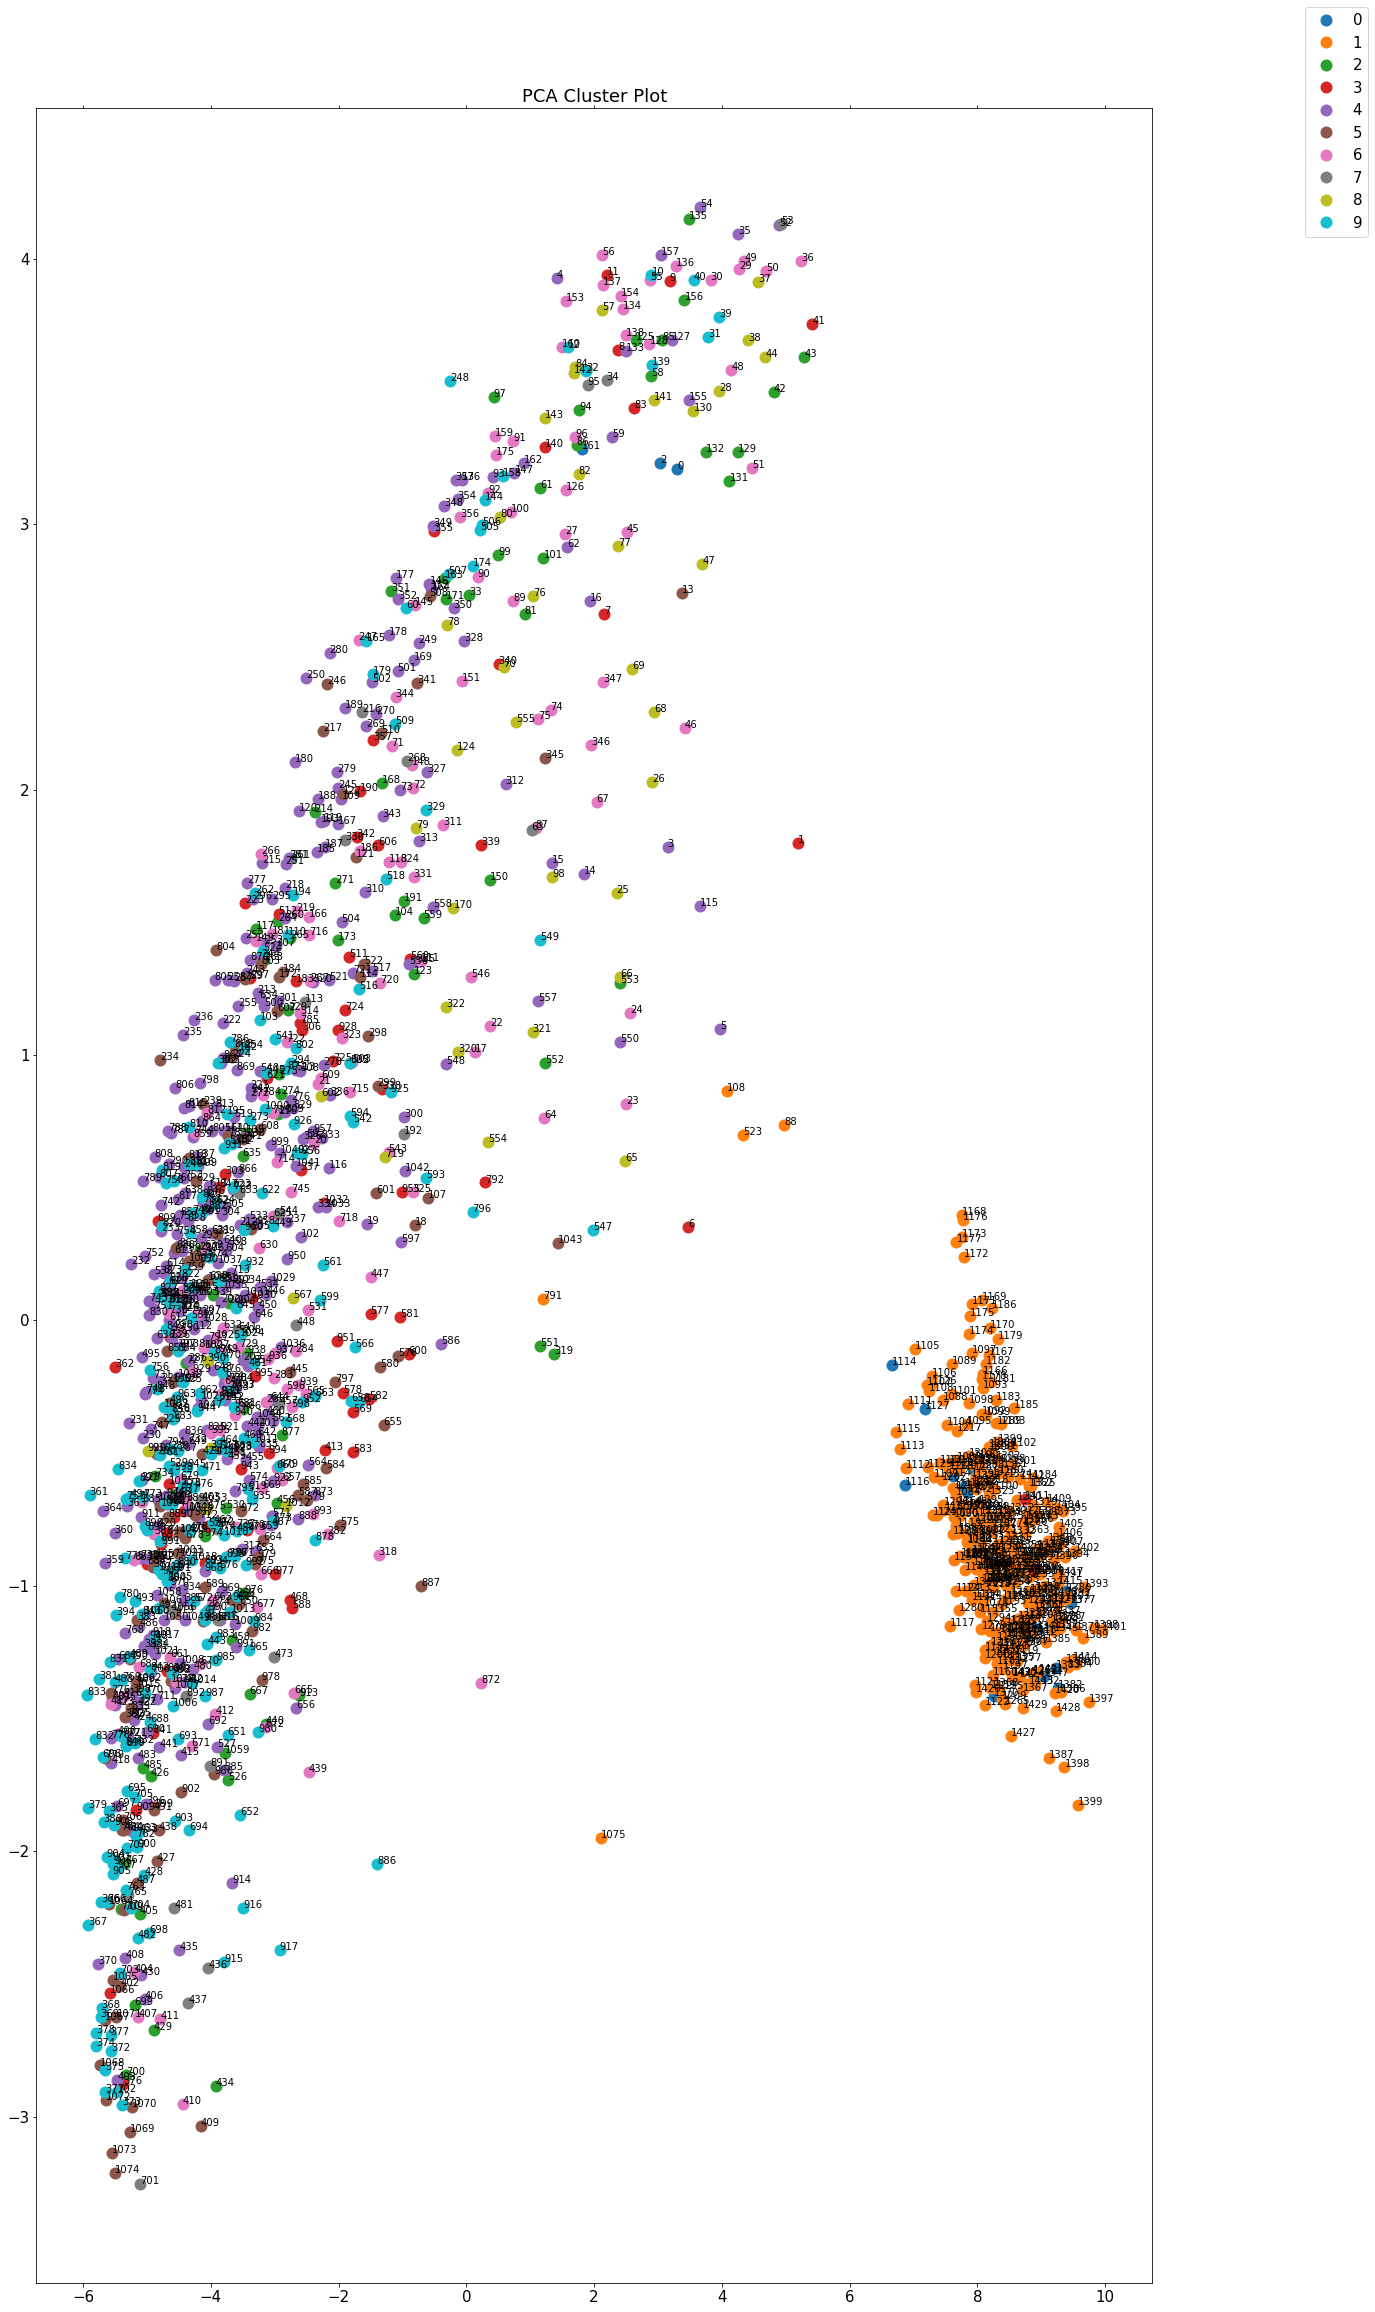

In [357]:
dist = 1 - cosine_similarity(feat_clips)
mds = PCA(n_components=2, random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

cluster_plot(pos, 'PCA Cluster Plot', height=40)

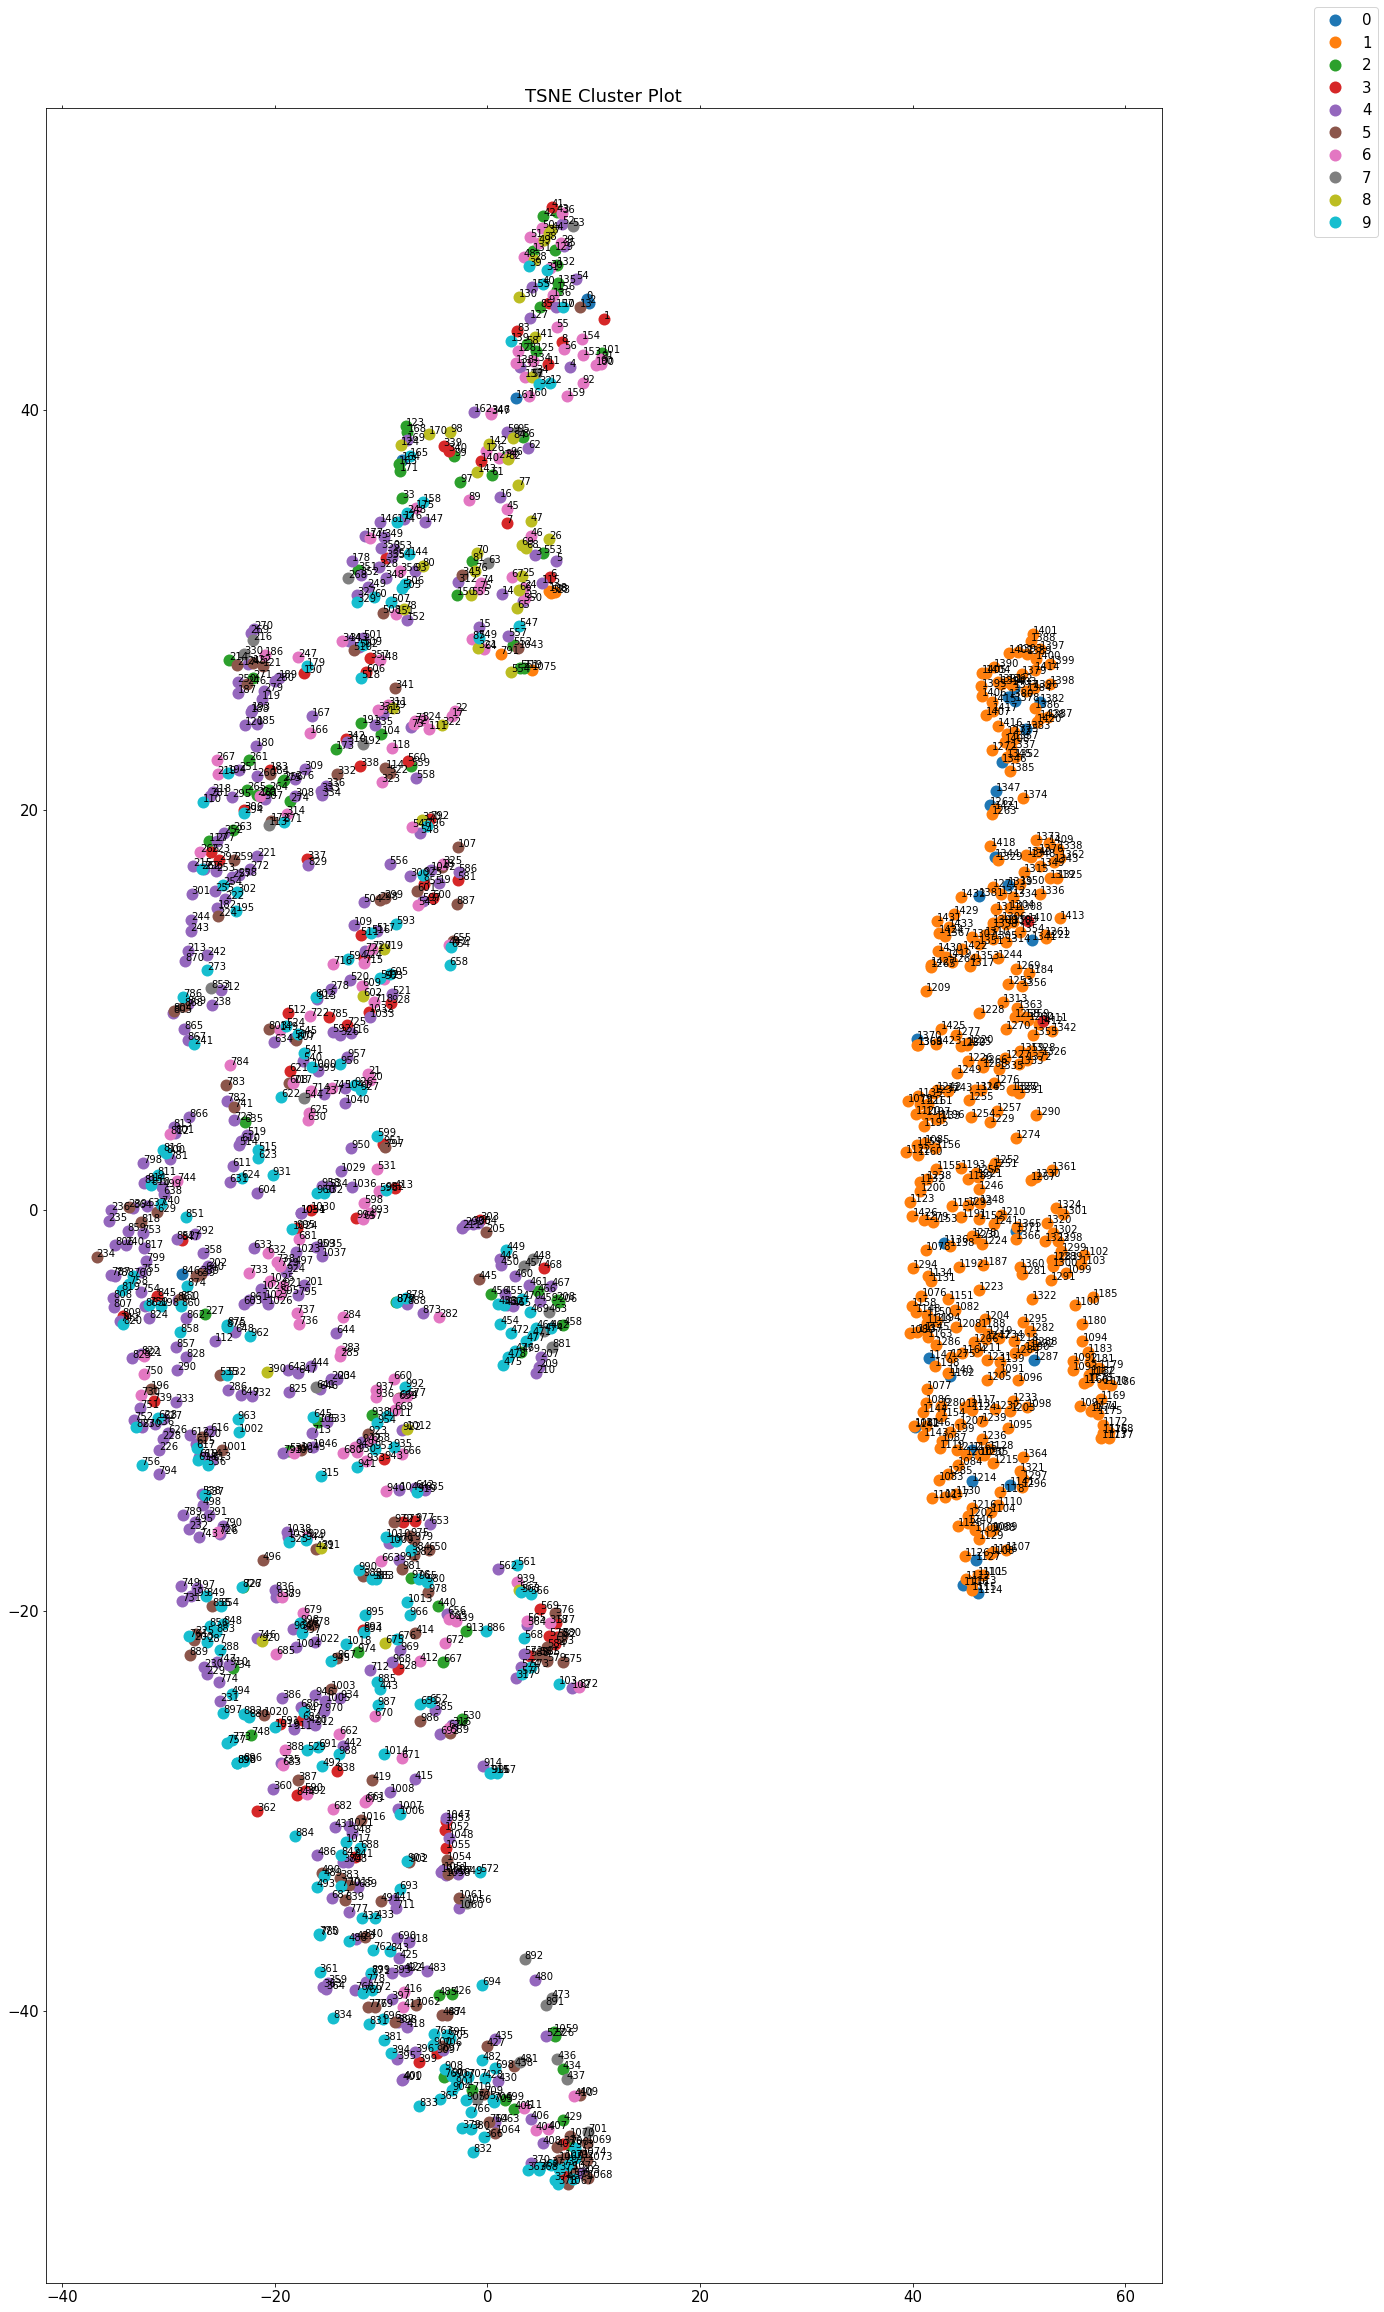

In [358]:
# Project the data onto 2D graph
dist = 1 - cosine_similarity(feat_clips)
mds = TSNE(n_components=2, random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

cluster_plot(pos, 'TSNE Cluster Plot', height=40)

Use these functions to listen to clips:

In [125]:
play_random_clip_in_cluster(511, clusters, option='clip')

Playing clip index 621 


In [359]:
play_clip(511)

To stop playing:

In [ ]:
sd.stop()

# Cluster Interpretation

In [141]:
# Prints: (Cluster number, count of clips in cluster)
Counter(clusters).most_common()

[(4, 358),
 (1, 336),
 (9, 235),
 (6, 149),
 (5, 112),
 (2, 75),
 (3, 73),
 (8, 40),
 (0, 30),
 (7, 26)]

In [ ]:
play_random_clip_in_cluster(7, clusters)

In [318]:
# Note: Not real labels; just for demonstration of code
cluster_names = ['quiet', 'loud', 'quiet', 'rain', 'birds', 'crickets', 'birds', 'quiet', 'quiet', 'loud']

Playing clip index 448 


In [ ]:
# Stop playing
sd.stop()

In [342]:
# See clip indexes of all clips inside cluster
clip_indexes = get_clip_indexes(7, clusters)
print(clip_indexes)

[34, 53, 63, 95, 113, 192, 216, 268, 330, 436, 437, 448, 457, 463, 473, 474, 481, 544, 641, 701, 765, 853, 881, 891, 892, 1056]


In [345]:
play_clip(34)

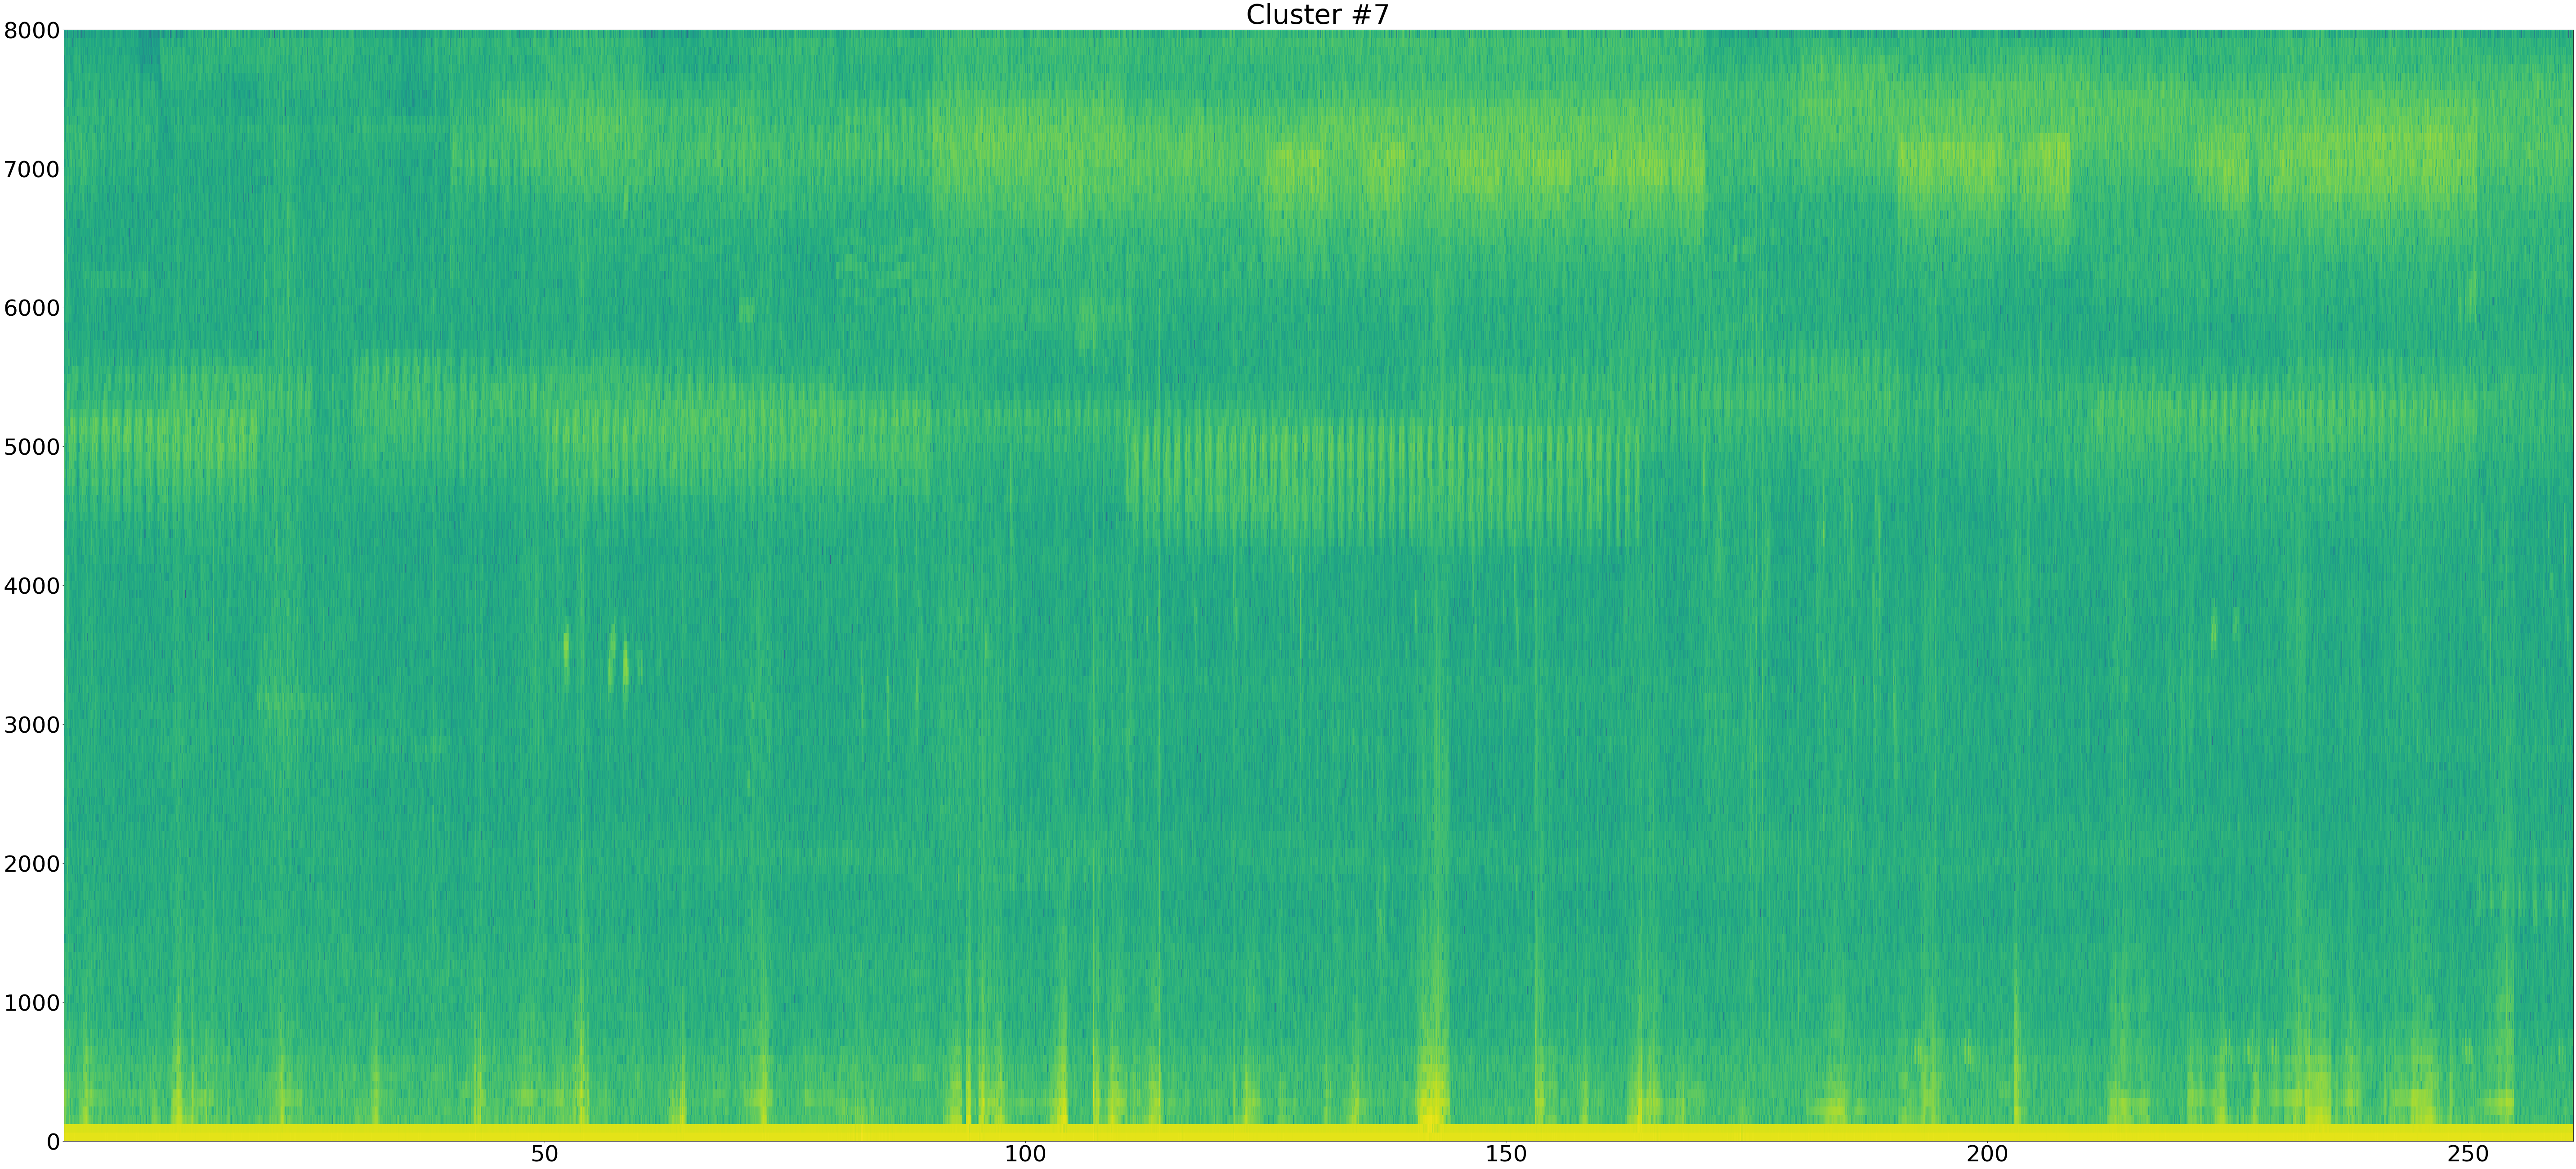

In [341]:
plot_spectrogram_of_cluster(samplerate, shorter_clips, 7, clusters, separate_channels=False)

# Visualization

In [320]:
num_clips = len(shorter_clips)
num_minutes = num_clips / 6
num_hours = num_minutes / 60

def clip_i_to_bin_i(clip_i):
    return int(clip_i / (num_clips/num_minutes))

def time_hist_for_cluster(cluster_i, clusters):
    hist_data = []
    for index in get_clip_indexes(cluster_i, clusters):
        index = clip_i_to_bin_i(index)
        hist_data.append(index)

    plt.ylim(0, (num_clips/num_minutes))
    plt.title('Cluster: %d (%s)' % (cluster_i, cluster_names[cluster_i]))
    plt.hist(hist_data, bins=int(num_minutes), range=[0, num_minutes])
    plt.show()
    
def colors(n):
    ret = []
    r = int(random.random() * 256)
    g = int(random.random() * 256)
    b = int(random.random() * 256)
    step = 256 / n
    for i in range(n):
        r += step
        g += step
        b += step
        r = int(r) % 256
        g = int(g) % 256
        b = int(b) % 256
        ret.append((r,g,b)) 
    return ret

def get_clusters_by_cluster_names(clusters, cluster_names):
    uniq_names = np.unique(cluster_names)
    print(uniq_names)
    new_clusters = [-1] * len(clusters)
    for uniq_name_i, uniq_name in enumerate(uniq_names):
        for name_i, name in enumerate(cluster_names):
            if name == uniq_name:
                # Assign name_i to each index in the cluster that has the same index
                for index in range(len(clusters)):
                    if clusters[index] == name_i:
                        new_clusters[index] = uniq_name_i
    return new_clusters

In [327]:
named_clusters = get_clusters_by_cluster_names(clusters, cluster_names)
Counter(named_clusters).most_common() 
cluster_names_to_plot = np.unique(cluster_names)

# Colors for visualization
jet = pl.get_cmap('jet', len(cluster_names_to_plot))
cluster_colors = {}
for i, name in enumerate(cluster_names_to_plot):
    cluster_colors[name] = jet(i)

['birds' 'crickets' 'loud' 'quiet' 'rain']


Note: These are not real labels for the clusters, this is just a demonstration of the code. The histogram visualization will be replaced with better visualizations for cluster/time data such as Rose Plots.

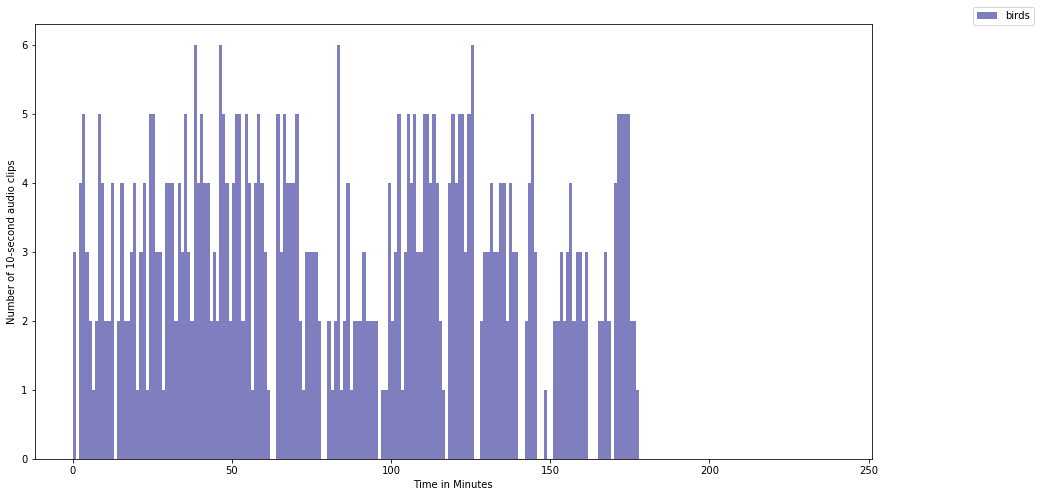

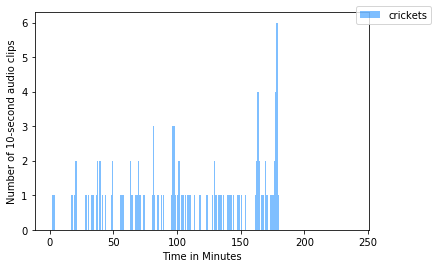

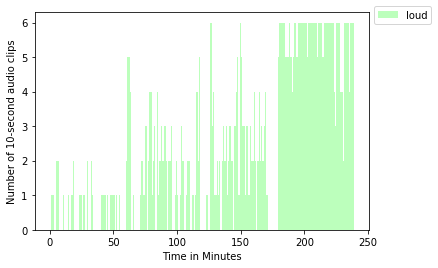

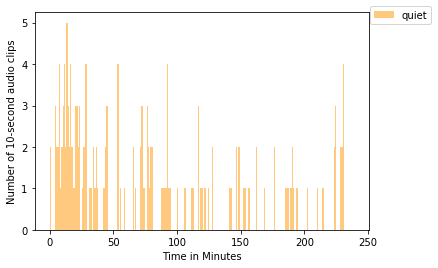

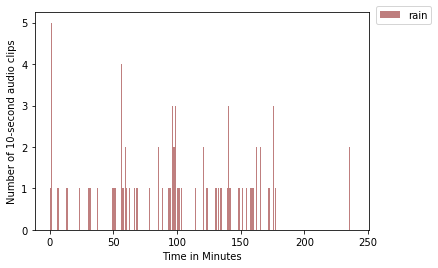

In [324]:
# TODO: Replace with better visualization like Rose Plots

def plot_all_histograms(clusters, cluster_names):
    plt.figure(figsize=(15,8))

    for cluster_i in range(len(cluster_names)):
        hist_data = []
        for index in get_clip_indexes(cluster_i, clusters):
            index = clip_i_to_bin_i(index)
            hist_data.append(index)

        cluster_name = cluster_names[cluster_i]
        c = cluster_colors[cluster_name]
        plt.hist(hist_data, bins=int(num_minutes), range=[0, num_minutes], alpha=0.5, color=c, label=cluster_name)

        plt.ylabel('Number of 10-second audio clips')
        plt.xlabel('Time in Minutes')
        plt.legend(bbox_to_anchor=(1.2, 1.05))
        plt.show()
    
clusters_to_plot = named_clusters
cluster_names_to_plot = np.unique(cluster_names)
plot_all_histograms(named_clusters, np.unique(cluster_names))